# LioNets: HateSpeech Dataset with Neural Networks and Embeddings-> Classification Task

In this notebook, we present how LioNets can be applied in predictive models using embeddings as inputs.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, SpatialDropout1D, CuDNNLSTM, Bidirectional, Dense, \
    LSTM, Conv1D, MaxPooling1D, Dropout, concatenate, Flatten, add, RepeatVector, ConvLSTM2D, TimeDistributed, Reshape
from keras import initializers, regularizers, constraints
from keras.models import model_from_json
from keras import objectives, backend as K
from keras.engine import Layer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Input, Model
from keras.optimizers import Adam
from keras.models import Sequential, clone_model
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, balanced_accuracy_score, accuracy_score
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import OrderedDict
import pandas as pd
pd.set_option('max_colwidth',400)

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from lionets import LioNets
from utilities.custom_attention import Attention
from utilities.load_dataset import Load_Dataset
from utilities.evaluation import Evaluation

from altruist.altruist import Altruist

from lime.lime_text import LimeTextExplainer
import innvestigate
import innvestigate.utils as iutils
from innvestigate.utils.keras import checks

Using TensorFlow backend.


In [2]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
X, y = Load_Dataset.load_hate_data(True,False)
X_unsup,y_unsup = Load_Dataset.load_hate_unsupervised_data(True,False)

In [4]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 
rus = RandomUnderSampler(random_state=42)
X_unsup,y_unsup = rus.fit_resample(np.array(X_unsup).reshape(-1, 1),y_unsup)

In [5]:
class_names = ['noHateSpeech', 'hateSpeech']
X_train, X_valid, y_train, y_valid =  train_test_split(X,y,test_size=0.2, stratify = y, random_state=0)

In [6]:
"""
import zipfile
!wget 'https://nlp.stanford.edu/data/glove.twitter.27B.zip'
with zipfile.ZipFile("glove.twitter.27B.zip", "r") as zip_ref:
    zip_ref.extractall()
    print(zip_ref.filelist)
del zip_ref
"""

'\nimport zipfile\n!wget \'https://nlp.stanford.edu/data/glove.twitter.27B.zip\'\nwith zipfile.ZipFile("glove.twitter.27B.zip", "r") as zip_ref:\n    zip_ref.extractall()\n    print(zip_ref.filelist)\ndel zip_ref\n'

In [7]:
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

In [8]:
def build_matrix(embedding_path, tk, max_features):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path, encoding = "utf-8"))

    word_index = tk.word_index
    nb_words = max_features
    embedding_matrix = np.zeros((nb_words + 1, 50))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix  

In [9]:
embedding_path1 = 'glove.twitter.27B.50d.txt' #GloveSmall
embed_size = 50

In [10]:
max_features = 1000
max_len = 50

In [11]:
X_train.shape, X_unsup.shape

((798,), (2860, 1))

In [12]:
tk = Tokenizer(lower = True, filters='', num_words=max_features, oov_token = True)
tk.fit_on_texts(np.concatenate((X_train,X_valid)))
train_tokenized = tk.texts_to_sequences(X_train)
valid_tokenized = tk.texts_to_sequences(X_valid)
X_tr = pad_sequences(train_tokenized, maxlen=max_len)
X_va = pad_sequences(valid_tokenized, maxlen=max_len)

usnup_tokenized = tk.texts_to_sequences([i[0] for i in X_unsup])
X_un = pad_sequences(usnup_tokenized, maxlen=max_len)

In [13]:
embedding_matrix = build_matrix(embedding_path1, tk, max_features)
embedding_matrix.shape

(1001, 50)

In [14]:
train_y = [0.1 if i <=0.5 else 0.9 for i in y_train]
valid_y = [0.1 if i <=0.5 else 0.9 for i in y_valid]
unsup_y = [0.1 if i <=0.5 else 0.9 for i in y_unsup]

In [15]:
file_path = "Hate_Predictor.hdf5"
check_point = ModelCheckpoint(file_path, monitor="val_loss", verbose=2,save_best_only=True, mode="auto")
main_input = Input(shape=(max_len,), dtype='int32', name='main_input')
embedding_input = (Embedding(max_features + 1, 50, input_length=max_len,  weights=[embedding_matrix], trainable=False))(main_input)

embedding_input2 = SpatialDropout1D(0.3)(embedding_input)

x = Bidirectional(LSTM(50, dropout=0.7, return_sequences=True))(embedding_input2)
encoder_x = concatenate([
    Attention(max_len)(x),
    GlobalMaxPooling1D()(x),
])

y = Conv1D(filters=50,kernel_size=3,activation='tanh')(embedding_input2)
encoder_y = GlobalMaxPooling1D()(y)

hidden = concatenate([encoder_x,encoder_y])

hidden = Dropout(0.7)(hidden)
hidden = Dense(500, activation='tanh')(hidden)
output_lay = Dense(1, activation='sigmoid')(hidden)
model = Model(inputs=[main_input], outputs=[output_lay])

In [16]:
model.compile(loss="binary_crossentropy", optimizer=Adam())

In [17]:
#model.fit(X_un, unsup_y, batch_size=128, epochs=50, verbose=2, shuffle=True) #warm start

In [18]:
#model.fit(X_tr, train_y, batch_size=128, 
#        epochs=100, validation_data=(X_va, valid_y), verbose=1, callbacks=[check_point], shuffle=True) #Fine tune

In [19]:
weights_file = 'weights/Hate_Predictor.hdf5' # choose the best checkpoint few features
model.load_weights(weights_file) # load it
model.compile(loss="binary_crossentropy", optimizer=Adam())

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, balanced_accuracy_score, accuracy_score

temp_predo1 = model.predict(X_tr)
predictions = [0 if i[0] <=0.5 else 1 for i in temp_predo1]
print('Train:',f1_score(y_train,predictions, average='macro'),f1_score(y_train,predictions, average='weighted'),
      balanced_accuracy_score(y_train,predictions),accuracy_score(y_train,predictions))

temp_predo2 = model.predict(X_va)
predictions = [0 if i[0] <=0.5 else 1 for i in temp_predo2]
print('Train:',f1_score(y_valid,predictions, average='macro'),f1_score(y_valid,predictions, average='weighted'),
      balanced_accuracy_score(y_valid,predictions), accuracy_score(y_valid,predictions))

Train: 0.7787692208503917 0.7834828520642375 0.7768619878254642 0.7844611528822055
Train: 0.7229064039408867 0.7286699507389162 0.7213915166310649 0.73


In [21]:
encoder = Model(input=model.input, output=[model.layers[-2].output])
encoder.trainable = False
encoder.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])

In [22]:
predictor_for_encoded = Sequential()
predictor_for_encoded.add(model.layers[len(model.layers)-1])

In [23]:
encoded_x_train = encoder.predict(X_tr)
encoded_x_valid = encoder.predict(X_va)
encoded_x_unsup = encoder.predict(X_un)

In [24]:
iw = tk.index_word.copy()
iw[1]='UKN'
X_T = []
for i in X_tr:
    X_T.append(' '.join([iw[o] for o in i if o !=0]))
X_V = []
for i in X_va:
    X_V.append(' '.join([iw[o] for o in i if o !=0]))
X_U = []
for i in X_un:
    X_U.append(' '.join([iw[o] for o in i if o !=0]))

In [25]:
X_train[5],X_T[5], X_unsup[5][0], X_U[5]

('comments likes and no views gg youtube',
 'comments UKN and no views UKN youtube',
 'all my white school teachers back in elementary knew not to give me no pussy am telling all of my niggas',
 'all my white school UKN back in UKN knew not to give me no UKN am UKN all of my UKN')

In [26]:
max_features_2 = max_features + 1
temp = np.zeros((X_tr.shape[0], max_len, max_features_2))
temp[np.expand_dims(np.arange(X_tr.shape[0]), axis=0).reshape(X_tr.shape[0], 1), 
     np.repeat(np.array([np.arange(max_len)]), X_tr.shape[0], axis=0), X_tr] = 1
X_train_one_hot = temp

temp = np.zeros((X_va.shape[0], max_len, max_features_2))
temp[np.expand_dims(np.arange(X_va.shape[0]), axis=0).reshape(X_va.shape[0], 1), 
     np.repeat(np.array([np.arange(max_len)]), X_va.shape[0], axis=0), X_va] = 1
X_valid_one_hot = temp

temp = np.zeros((X_un.shape[0], max_len, max_features_2))
temp[np.expand_dims(np.arange(X_un.shape[0]), axis=0).reshape(X_un.shape[0], 1), 
     np.repeat(np.array([np.arange(max_len)]), X_un.shape[0], axis=0), X_un] = 1
X_unsup_one_hot = temp

In [27]:
X_train_one_hot.shape

(798, 50, 1001)

In [28]:
encoded_input = Input(shape=(encoded_x_train[0].shape))
main_inp = Dense(1000, activation='tanh')(encoded_input)
repres = []
for i in range(50):
    hidden = Dense(1001, activation='softmax')(main_inp)
    repres.append(hidden)
con = concatenate(repres)
con = Reshape((50,1001),input_shape=(50050,))(con)
#con = LSTM(1001, dropout=0.7, activation='softmax',return_sequences=True)(con)
decoder = Model(encoded_input,con)
#decoder.summary()
decoder.compile(optimizer="Adam",loss=['categorical_crossentropy'],metrics=['mae'])

checkpoint_name = 'Hate_Decoder.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

In [29]:
#decoder.fit(encoded_x_unsup, X_unsup_one_hot,
#             epochs=100, batch_size=256, shuffle=True,
#             verbose=2, callbacks=[checkpoint])

In [30]:
#decoder.fit(encoded_x_train, X_train_one_hot, 
#             epochs=200, batch_size=128, shuffle=True, 
#             validation_data=(encoded_x_valid, X_valid_one_hot), 
#             verbose=1, callbacks=[checkpoint])

In [31]:
wights_file = 'weights/Hate_Decoder.hdf5' # choose the best checkpoint few features
decoder.load_weights(wights_file) # load it
decoder.compile(optimizer="Adam",loss=['categorical_crossentropy'],metrics=['mae'])

In [32]:
decoder.evaluate(encoded_x_train,X_train_one_hot)

798/798 [==============================] - 2s 3ms/step


[0.07357196041142433, 0.00010854411888622532]

In [33]:
decoder.evaluate(encoded_x_valid,X_valid_one_hot)

200/200 [==============================] - 0s 2ms/step


[0.07654393821954728, 0.00011106041754828766]

In [34]:
tk.index_word[1]='UKN'

In [35]:
tk.word_index['UKN'] = 1

In [36]:
decoded_x_train = decoder.predict(encoded_x_train) 
temp = []
for j in range(len(decoded_x_train)):
    tempo = decoded_x_train[j]
    tempo_ind = []
    for i in tempo:
        tempo_ind.append(np.argmax(i))
    temp.append(tempo_ind)
decoded_x_train = np.array(temp)

decoded_x_valid = decoder.predict(encoded_x_valid) 
temp = []
for j in range(len(decoded_x_valid)):
    tempo = decoded_x_valid[j]
    tempo_ind = []
    for i in tempo:

        tempo_ind.append(np.argmax(i))
    temp.append(tempo_ind)
decoded_x_valid = np.array(temp)

In [37]:
temp_pred = model.predict(X_tr)
predictions1 = [0 if i[0] <=0.5 else 1 for i in temp_pred]
predictions7 = [i[0] for i in temp_pred]

temp_pred = model.predict(X_va)
predictions2 = [0 if i[0] <=0.5 else 1 for i in temp_pred]
predictions8 = [i[0] for i in temp_pred]

temp_pred = model.predict(decoded_x_train)
predictions3 = [0 if i[0] <=0.5 else 1 for i in temp_pred]
print('Train dec:',f1_score(predictions1,predictions3, average='weighted'),balanced_accuracy_score(predictions1,predictions3))
temp_pred = model.predict(decoded_x_valid)
predictions4 = [0 if i[0] <=0.5 else 1 for i in temp_pred]
print('Test dec:',f1_score(predictions2,predictions4, average='weighted'),balanced_accuracy_score(predictions2,predictions4))

temp_pred = model.predict(decoded_x_train)
predictions5 = [i[0] for i in temp_pred]
print('Train dec mae:',mean_absolute_error(predictions7,predictions5))
temp_pred = model.predict(decoded_x_valid)
predictions6 = [i[0] for i in temp_pred]
print('Train dec mae:',mean_absolute_error(predictions8,predictions6))

Train dec: 0.9937296472786397 0.9927723081731521
Test dec: 0.99 0.9896254798215582
Train dec mae: 0.0064623
Train dec mae: 0.006024531


In [38]:
instances_evaluation = decoder.predict(encoded_x_train[40:46]) 

In [39]:
for j in range(len(instances_evaluation)):
    tempo = X_train_one_hot[j+40]
    tempo_ind = []
    tempo_str = ""
    for i in tempo:
        tempo_ind.append(np.argmax(i))
        if np.argmax(i) != 0 and np.argmax(i)!=True:
            tempo_str = tempo_str + tk.index_word[np.argmax(i)]+" "
        elif np.argmax(i) == True:
            tempo_str = tempo_str + 'UKN'+ " "
    print(" Original:",tempo_str)

    tempo = instances_evaluation[j]
    tempo_ind = []
    tempo_str = ""
    for i in tempo:
        tempo_ind.append(np.argmax(i))
        if np.argmax(i) != 0 and np.argmax(i)!=True:
            #print(sorted(i,reverse=True)[:5])
            #print(i.max(),tk.index_word[np.argmax(i)])
            tempo_str = tempo_str + tk.index_word[np.argmax(i)]+" "
        elif np.argmax(i) == True:
            tempo_str = tempo_str + 'UKN'+ " "
    print("  Decoded:",tempo_str)
    print('""""""""""""""""""')

 Original: if were you would UKN lethal UKN to my sick child UKN 
  Decoded: if were you would UKN lethal UKN UKN my sick child UKN 
""""""""""""""""""
 Original: UKN UKN asians UKN less crime than us well this is because they are UKN UKN UKN white power 
  Decoded: UKN asians UKN less crime than us well this is because they are UKN UKN UKN white power 
""""""""""""""""""
 Original: maybe it is because you are autistic wish you death 
  Decoded: maybe it UKN because you are autistic wish you death 
""""""""""""""""""
 Original: if they are so much like family why don they treat them like family and UKN thier UKN 
  Decoded: if they are so much like family why don they treat them like family and UKN thier UKN 
""""""""""""""""""
 Original: my parents are UKN 
  Decoded: my parents are UKN 
""""""""""""""""""
 Original: disgusting sick UKN kill yourself 
  Decoded: disgusting sick UKN kill yourself 
""""""""""""""""""


In [40]:
instances_evaluation = decoder.predict(encoded_x_valid[11:17]) 

In [41]:
for j in range(len(instances_evaluation)):
    tempo = X_valid_one_hot[j+11]
    tempo_ind = []
    tempo_str = ""
    for i in tempo:
        tempo_ind.append(np.argmax(i))
        if np.argmax(i) != 0 and np.argmax(i)!=True:
            tempo_str = tempo_str + tk.index_word[np.argmax(i)]+" "
        elif np.argmax(i) == True:
            tempo_str = tempo_str + 'UKN'+ " "
    print(" Original",tempo_str)

    tempo = instances_evaluation[j]
    tempo_ind = []
    tempo_str = ""
    for i in tempo:
        tempo_ind.append(np.argmax(i))
        if np.argmax(i) != 0 and np.argmax(i)!=True:
            tempo_str = tempo_str + tk.index_word[np.argmax(i)]+" "
        elif np.argmax(i) == True:
            tempo_str = tempo_str + 'UKN'+ " "
    print("  Decoded:",tempo_str)
    print('""""""""""""""""""')

 Original as black person think that UKN should stop UKN the word in the song UKN you should be proud of being white am proud of being black so 
  Decoded: as black person think that UKN should stop UKN the word in the song UKN you should be proud of being white am proud of being black so 
""""""""""""""""""
 Original homo so you fuck your brother instead of your UKN 
  Decoded: homo so you fuck your brother instead of your UKN 
""""""""""""""""""
 Original indian UKN UKN you look like you UKN UKN UKN women on UKN 
  Decoded: indian UKN UKN you look like UKN UKN UKN UKN women on UKN 
""""""""""""""""""
 Original UKN is the UKN that comes out of UKN dream UKN 
  Decoded: is UKN that comes out of of dream UKN 
""""""""""""""""""
 Original what the fuck stupid people 
  Decoded: what the fuck stupid people 
""""""""""""""""""
 Original islam is the true religion believe it UKN 
  Decoded: islam is the true religion believe it UKN 
""""""""""""""""""


## LioNets Experiments
Having everything setted up, we are now ready to try our methodology, Gradient x Input and LIME.

In [42]:
from sklearn.linear_model import Ridge
transparent_model = Ridge(alpha=0.01,fit_intercept=True,random_state=0)

lionet = LioNets(model, decoder, encoder, X_tr, decoder_lower_threshold=0, double_detector=True, 
                 embeddings=True, tk=tk, word_apheresis=False)
lionetWA = LioNets(model, decoder, encoder, X_tr, decoder_lower_threshold=0, double_detector=True, 
                 embeddings=True, tk=tk, word_apheresis=True)

In [43]:
import random 
random.seed(2000)
train = np.array(random.sample(list(X_tr),200))
valid = np.array(X_va[:200]) #X_V is 200 already
train.shape, valid.shape

((200, 50), (200, 50))

Let's calculate the fidelity of Lime and LioNets

In [44]:
split_expression = lambda s: re.split(r'\W+', s)
explainer = LimeTextExplainer(class_names=class_names, split_expression=split_expression)
def lime_predict(text):
    i = tk.texts_to_sequences(text)
    i = pad_sequences(i, maxlen=max_len)
    a = model.predict(i)
    b = 1 - a 
    return np.column_stack((b,a))

In [45]:
def tts(text):
    sent = ''
    for i in text:    
        if i != 0:
            sent = sent + tk.index_word[i] + ' '
    sent = sent[:-1]
    return sent

In [46]:
def fi_lime(text):
    explanation = explainer.explain_instance(text_instance=tts(text), classifier_fn=lime_predict)
    local_pred = explanation.local_pred[0]
    return local_pred #This is because lime interprets class with label 1
def fi_lionets(text):
    _, _, loc_res, _, _ = lionet.explain_instance(text,8000,transparent_model)
    return loc_res[0]
def fi_lionetsWA(text):
    _, _, loc_res, _, _ = lionetWA.explain_instance(text,6500,transparent_model)
    return loc_res[0]

In [47]:
evaluator = Evaluation(model.predict,None,None,True)

In [49]:
fidelity = evaluator.fidelity(train, [fi_lime, fi_lionets, fi_lionetsWA], class_n=0)
print('Train:')
print('  Lime fidelity:', fidelity[0][0])
print('  LioNets fidelity:', fidelity[1][0])
print('  LioNetsWA fidelity:', fidelity[2][0])
fidelity = evaluator.fidelity(valid, [fi_lime, fi_lionets, fi_lionetsWA], class_n=0)
print('Valid:')
print('  Lime fidelity:', fidelity[0][0])
print('  LioNets fidelity:', fidelity[1][0])
print('  LioNetsWA fidelity:', fidelity[2][0])

Train:
  Lime fidelity: 0.019238350909563256
  LioNets fidelity: 0.002254678248197535
  LioNetsWA fidelity: 0.002040795748711755
Valid:
  Lime fidelity: 0.022016530893771803
  LioNets fidelity: 0.0025515270719612365
  LioNetsWA fidelity: 0.0020900368210683682


Let's calculate the non zero weights

In [50]:
Xs = iutils.to_list(model.outputs)
softmax_found = False
ret = []
for x in Xs:
    layer, node_index, tensor_index = x._keras_history
    if checks.contains_activation(layer, activation="sigmoid"):
        softmax_found = True
        if isinstance(layer, keras.layers.Activation):
            ret.append(layer.get_input_at(node_index))
        else:
            layer_wo_act = innvestigate.utils.keras.graph.copy_layer_wo_activation(layer)
            ret.append(layer_wo_act(layer.get_input_at(node_index)))

In [51]:
model2 = Model(input=model.input, output=ret)
model2.trainable = False
model2.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=["accuracy"])
analyzer = innvestigate.create_analyzer('lrp.epsilon', model2, neuron_selection_mode='max_activation', **{'epsilon': 1})

In [52]:
def fi_LRP(X_t):
    ooo = analyzer.analyze(np.array([X_t]))[0]
    ooo = ooo*np.array([0 if i == 0 else 1 for i in X_t]) #only on lrp
    return [ooo][0]

In [53]:
def fi_lime(text):
    sent=tts(text)
    explanation = explainer.explain_instance(text_instance=sent, classifier_fn=lime_predict)
    weights = OrderedDict(explanation.as_list())
    lime_w = {}
    for k,v in weights.items():
        lime_w[tk.word_index[k]] = v
    interpretation = []
    for i in text:
        if i == 0:
            interpretation.append(0)
        else:
            if i in lime_w.keys():
                interpretation.append(lime_w[i])
            else:
                interpretation.append(0)
    return np.array([interpretation])[0]

In [54]:
def fi_lionets(text):
    weights, _, _, names, instance = lionet.explain_instance(text,8000,transparent_model)
    weights = weights
    lionets_w = {}
    for i in range(len(list(weights[0]))):
        v = weights[0][i]
        k = names[i]
        if k == 'ukn':
            lionets_w[tk.word_index['UKN']] = v
        else:
            lionets_w[tk.word_index[k]] = v
    interpretation = []
    for i in text:
        if i == 0:
            interpretation.append(0)
        else:
            if i in lionets_w:
                interpretation.append(lionets_w[i])
            else:
                interpretation.append(0)
    return np.array([interpretation])[0]

In [55]:
def fi_lionetsWA(text):
    weights, _, _, names, instance = lionetWA.explain_instance(text,6500,transparent_model)
    weights = weights 
    lionets_w = {}
    for i in range(len(list(weights[0]))):
        v = weights[0][i]
        k = names[i]
        if k == 'ukn':
            lionets_w[tk.word_index['UKN']] = v
        else:
            lionets_w[tk.word_index[k]] = v
    interpretation = []
    for i in text:
        if i == 0:
            interpretation.append(0)
        else:
            if i in lionets_w:
                interpretation.append(lionets_w[i])
            else:
                interpretation.append(0)
    return np.array([interpretation])[0]

In [56]:
non_zero = evaluator.non_zero_weights(train, [fi_LRP, fi_lime, fi_lionets, fi_lionetsWA])
print('Train:')
print('  LRP Non Zero:', non_zero[0][0])
print('  Lime Non Zero:', non_zero[1][0])
print('  LioNets Non Zero:', non_zero[2][0])
print('  LioNetsWA Non Zero:', non_zero[3][0])
non_zero = evaluator.non_zero_weights(valid, [fi_LRP, fi_lime, fi_lionets, fi_lionetsWA])
print('Valid:')
print('  LRP Non Zero:', non_zero[0][0])
print('  Lime Non Zero:', non_zero[1][0])
print('  LioNets Non Zero:', non_zero[2][0])
print('  LioNetsWA Non Zero:', non_zero[3][0])

in EmbeddingReverseLayer.init: Embedding -> Dedicated ReverseLayer class
[<tf.Tensor 'gradient_wrt_12/gradients/AddN:0' shape=(?, 50, 50) dtype=float32>]
Train:
  LRP Non Zero: 17.43
  Lime Non Zero: 11.49
  LioNets Non Zero: 14.665
  LioNetsWA Non Zero: 17.43
Valid:
  LRP Non Zero: 15.61
  Lime Non Zero: 10.625
  LioNets Non Zero: 14.04
  LioNetsWA Non Zero: 15.61


Let's calculate the robustness

In [59]:
robustness = evaluator.robustness_embeddings(train,[fi_lime, fi_LRP, fi_lionets, fi_lionetsWA])
print('Train:')
print('  Lime Robustness:', robustness[0])
print('  LRP Robustness:', robustness[1])
print('  LioNets Robustness:', robustness[2])
print('  LioNetsWA Robustness:', robustness[3])
robustness = evaluator.robustness_embeddings(valid,[fi_lime, fi_LRP, fi_lionets, fi_lionetsWA])
print('Valid:')
print('  Lime Robustness:', robustness[0])
print('  LRP Robustness:', robustness[1])
print('  LioNets Robustness:', robustness[2])
print('  LioNetsWA Robustness:', robustness[3])

Train:
  Lime Robustness: 0.015046410415427895
  LRP Robustness: 0.011387657223302278
  LioNets Robustness: 0.04347145226588844
  LioNetsWA Robustness: 0.02609949411069894
Valid:
  Lime Robustness: 0.013570505676064078
  LRP Robustness: 0.011255281901008782
  LioNets Robustness: 0.03805127550239647
  LioNetsWA Robustness: 0.02351208629261814


Altruist

In [ ]:
features = []
for i in range(50):
    features.append(str('f'+str(i)))

In [ ]:
def fi_LRP(X_t,prediction,model):
    ooo = analyzer.analyze(np.array([X_t]))[0]
    ooo = ooo*np.array([0 if i == 0 else 1 for i in X_t]) #only on lrp
    return [ooo][0]
def fi_lime(text,prediction,model):
    sent=tts(text)
    explanation = explainer.explain_instance(text_instance=sent, classifier_fn=lime_predict)
    weights = OrderedDict(explanation.as_list())
    lime_w = {}
    for k,v in weights.items():
        lime_w[tk.word_index[k]] = v
    interpretation = []
    for i in text:
        if i == 0:
            interpretation.append(0)
        else:
            if i in lime_w.keys():
                interpretation.append(lime_w[i])
            else:
                interpretation.append(0)
    return np.array([interpretation])[0]
def fi_lionets(text,prediction,model):
    weights, _, _, names, _ = lionet.explain_instance(text,8000,transparent_model)
    lionets_w = {}
    for i in range(len(list(weights[0]))):
        v = weights[0][i]
        k = names[i]
        if k == 'ukn':
            lionets_w[tk.word_index['UKN']] = v
        else:
            lionets_w[tk.word_index[k]] = v
    interpretation = []
    for i in text:
        if i == 0:
            interpretation.append(0)
        else:
            if i in lionets_w:
                interpretation.append(lionets_w[i])
            else:
                interpretation.append(0)
    return np.array([interpretation])[0]
def fi_lionetsWA(text,prediction,model):
    weights, _, _, names, _ = lionetWA.explain_instance(text,6500,transparent_model)
    lionets_w = {}
    for i in range(len(list(weights[0]))):
        v = weights[0][i]
        k = names[i]
        if k == 'ukn':
            lionets_w[tk.word_index['UKN']] = v
        else:
            lionets_w[tk.word_index[k]] = v
    interpretation = []
    for i in text:
        if i == 0:
            interpretation.append(0)
        else:
            if i in lionets_w:
                interpretation.append(lionets_w[i])
            else:
                interpretation.append(0)
    return np.array([interpretation])[0]

In [ ]:
print("*Please let it run, it will take time probably*")
fi_names = {fi_LRP:'LRP',fi_lime:'Lime', fi_lionets:'LioNets', fi_lionetsWA:'LioNetsWA'}
fis = [fi_LRP, fi_lime, fi_lionets, fi_lionetsWA]

fis_scores = []
for i in fis:
    fis_scores.append([])
count = 0

altruistino = Altruist(model, train, fis, features, None, True, None, True)

for instance in train:            
    if (count + 1) % 25 == 0:
        print(count+1,"/",len(valid),"..",end=", ")
    #print(len(instance))
    count = count + 1
    untruthful_features = altruistino.find_untruthful_features(instance)
    for i in range(len(untruthful_features[0])):
        fis_scores[i].append(len(untruthful_features[0][i]))
count = 0
print()
print('Train:')
for fis_score in fis_scores:
    fi = fis[count]
    count = count + 1
    print(' ',fi_names[fi],np.array(fis_score).mean())

In [ ]:
print("*Please let it run, it will take time probably*")
fi_names = {fi_LRP:'LRP',fi_lime:'Lime', fi_lionets:'LioNets', fi_lionetsWA:'LioNetsWA'}
fis = [fi_LRP, fi_lime, fi_lionets, fi_lionetsWA]
fis_scores = []
for i in fis:
    fis_scores.append([])
count = 0

for instance in valid:            
    if (count + 1) % 25 == 0:
        print(count+1,"/",len(valid),"..",end=", ")
    #print(len(instance))
    count = count + 1
    untruthful_features = altruistino.find_untruthful_features(instance)
    for i in range(len(untruthful_features[0])):
        fis_scores[i].append(len(untruthful_features[0][i]))
count = 0
print()
print('Valid:')
for fis_score in fis_scores:
    fi = fis[count]
    count = count + 1
    print(' ',fi_names[fi],np.array(fis_score).mean())

## Qualitative:

Now we will test an instance and its explanations

In [56]:
X_T[22]

'or maybe just do not follow UKN UKN religions from the middle UKN'

In [59]:
Xreal, _ = Load_Dataset.load_hate_data(False,False)
for xrel in Xreal:
    if 'ayb' in xrel and 'ollow' in xrel:
        print(xrel)

Or maybe just don't follow degenerate sandnigger religions from the middle east?


In [96]:
weights, a, b, names, c = lionetWA.explain_instance(X_tr[22],6500,transparent_model)

In [97]:
lionets_w = {}
for v,k in dict(zip(list(weights[0]), list(names))).items():
    if k == 'ukn':
        lionets_w[tk.word_index['UKN']] = v
    else:
        lionets_w[tk.word_index[k]] = v
interpretation = []
for i in X_tr[22]:
    if i != 0:
        interpretation.append([tk.index_word[i],lionets_w[i]])

In [98]:
interpretation, a, b

([['or', -0.0013547213141519084],
  ['maybe', -0.0005801693509350953],
  ['just', -0.019182554157719838],
  ['do', 0.009960080109836443],
  ['not', -7.265478265681303e-30],
  ['follow', 4.4686165888387454e-07],
  ['UKN', -0.003628904163403668],
  ['UKN', -0.003628904163403668],
  ['religions', 0.00042983227201239216],
  ['from', -0.010532765061780856],
  ['the', -0.01690129474145001],
  ['middle', 0.021194400084367297],
  ['UKN', -0.003628904163403668]],
 array([0.73036736], dtype=float32),
 array([0.72908424]))

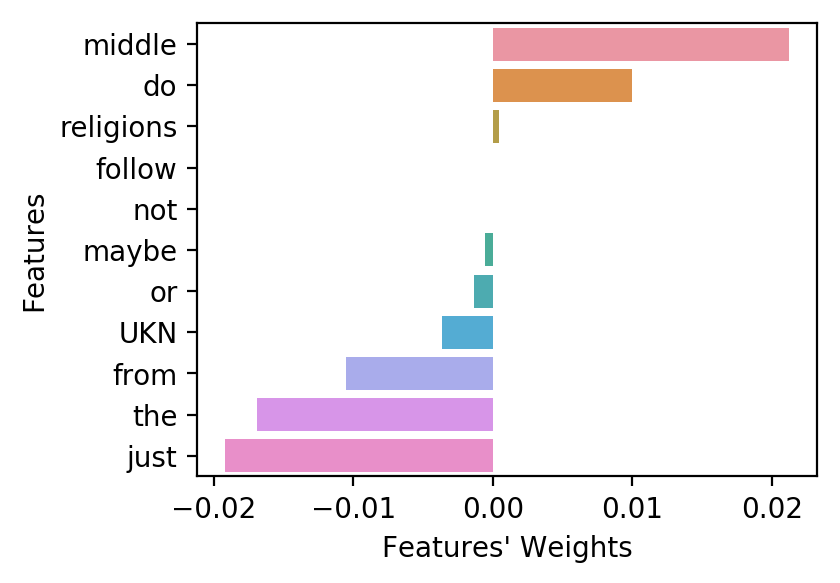

In [106]:
import seaborn as sns
plt.figure(num=None, figsize=(4, 3), dpi=200, facecolor='w', edgecolor='k')
i_weights = pd.DataFrame({"Features": [o[0] for o in np.array(interpretation)[:,:1]], 
                                  "Features' Weights": [float(o[0]) for o in np.array(interpretation)[:,1:]]})
i_weights = i_weights.sort_values(by="Features' Weights", ascending=False)
i_weights = i_weights[(i_weights["Features' Weights"] != 0)]   
i_weights = i_weights.drop_duplicates()
sns.barplot(x="Features' Weights", y="Features", data=i_weights)
plt.show()

In [107]:
lime_predict(['or maybe just do not follow UKN UKN religions from the middle UKN'])[0][1]

0.7303675

In [108]:
lime_predict(['or maybe just do not follow UKN UKN religions from the UKN'])[0][1]

0.70300514

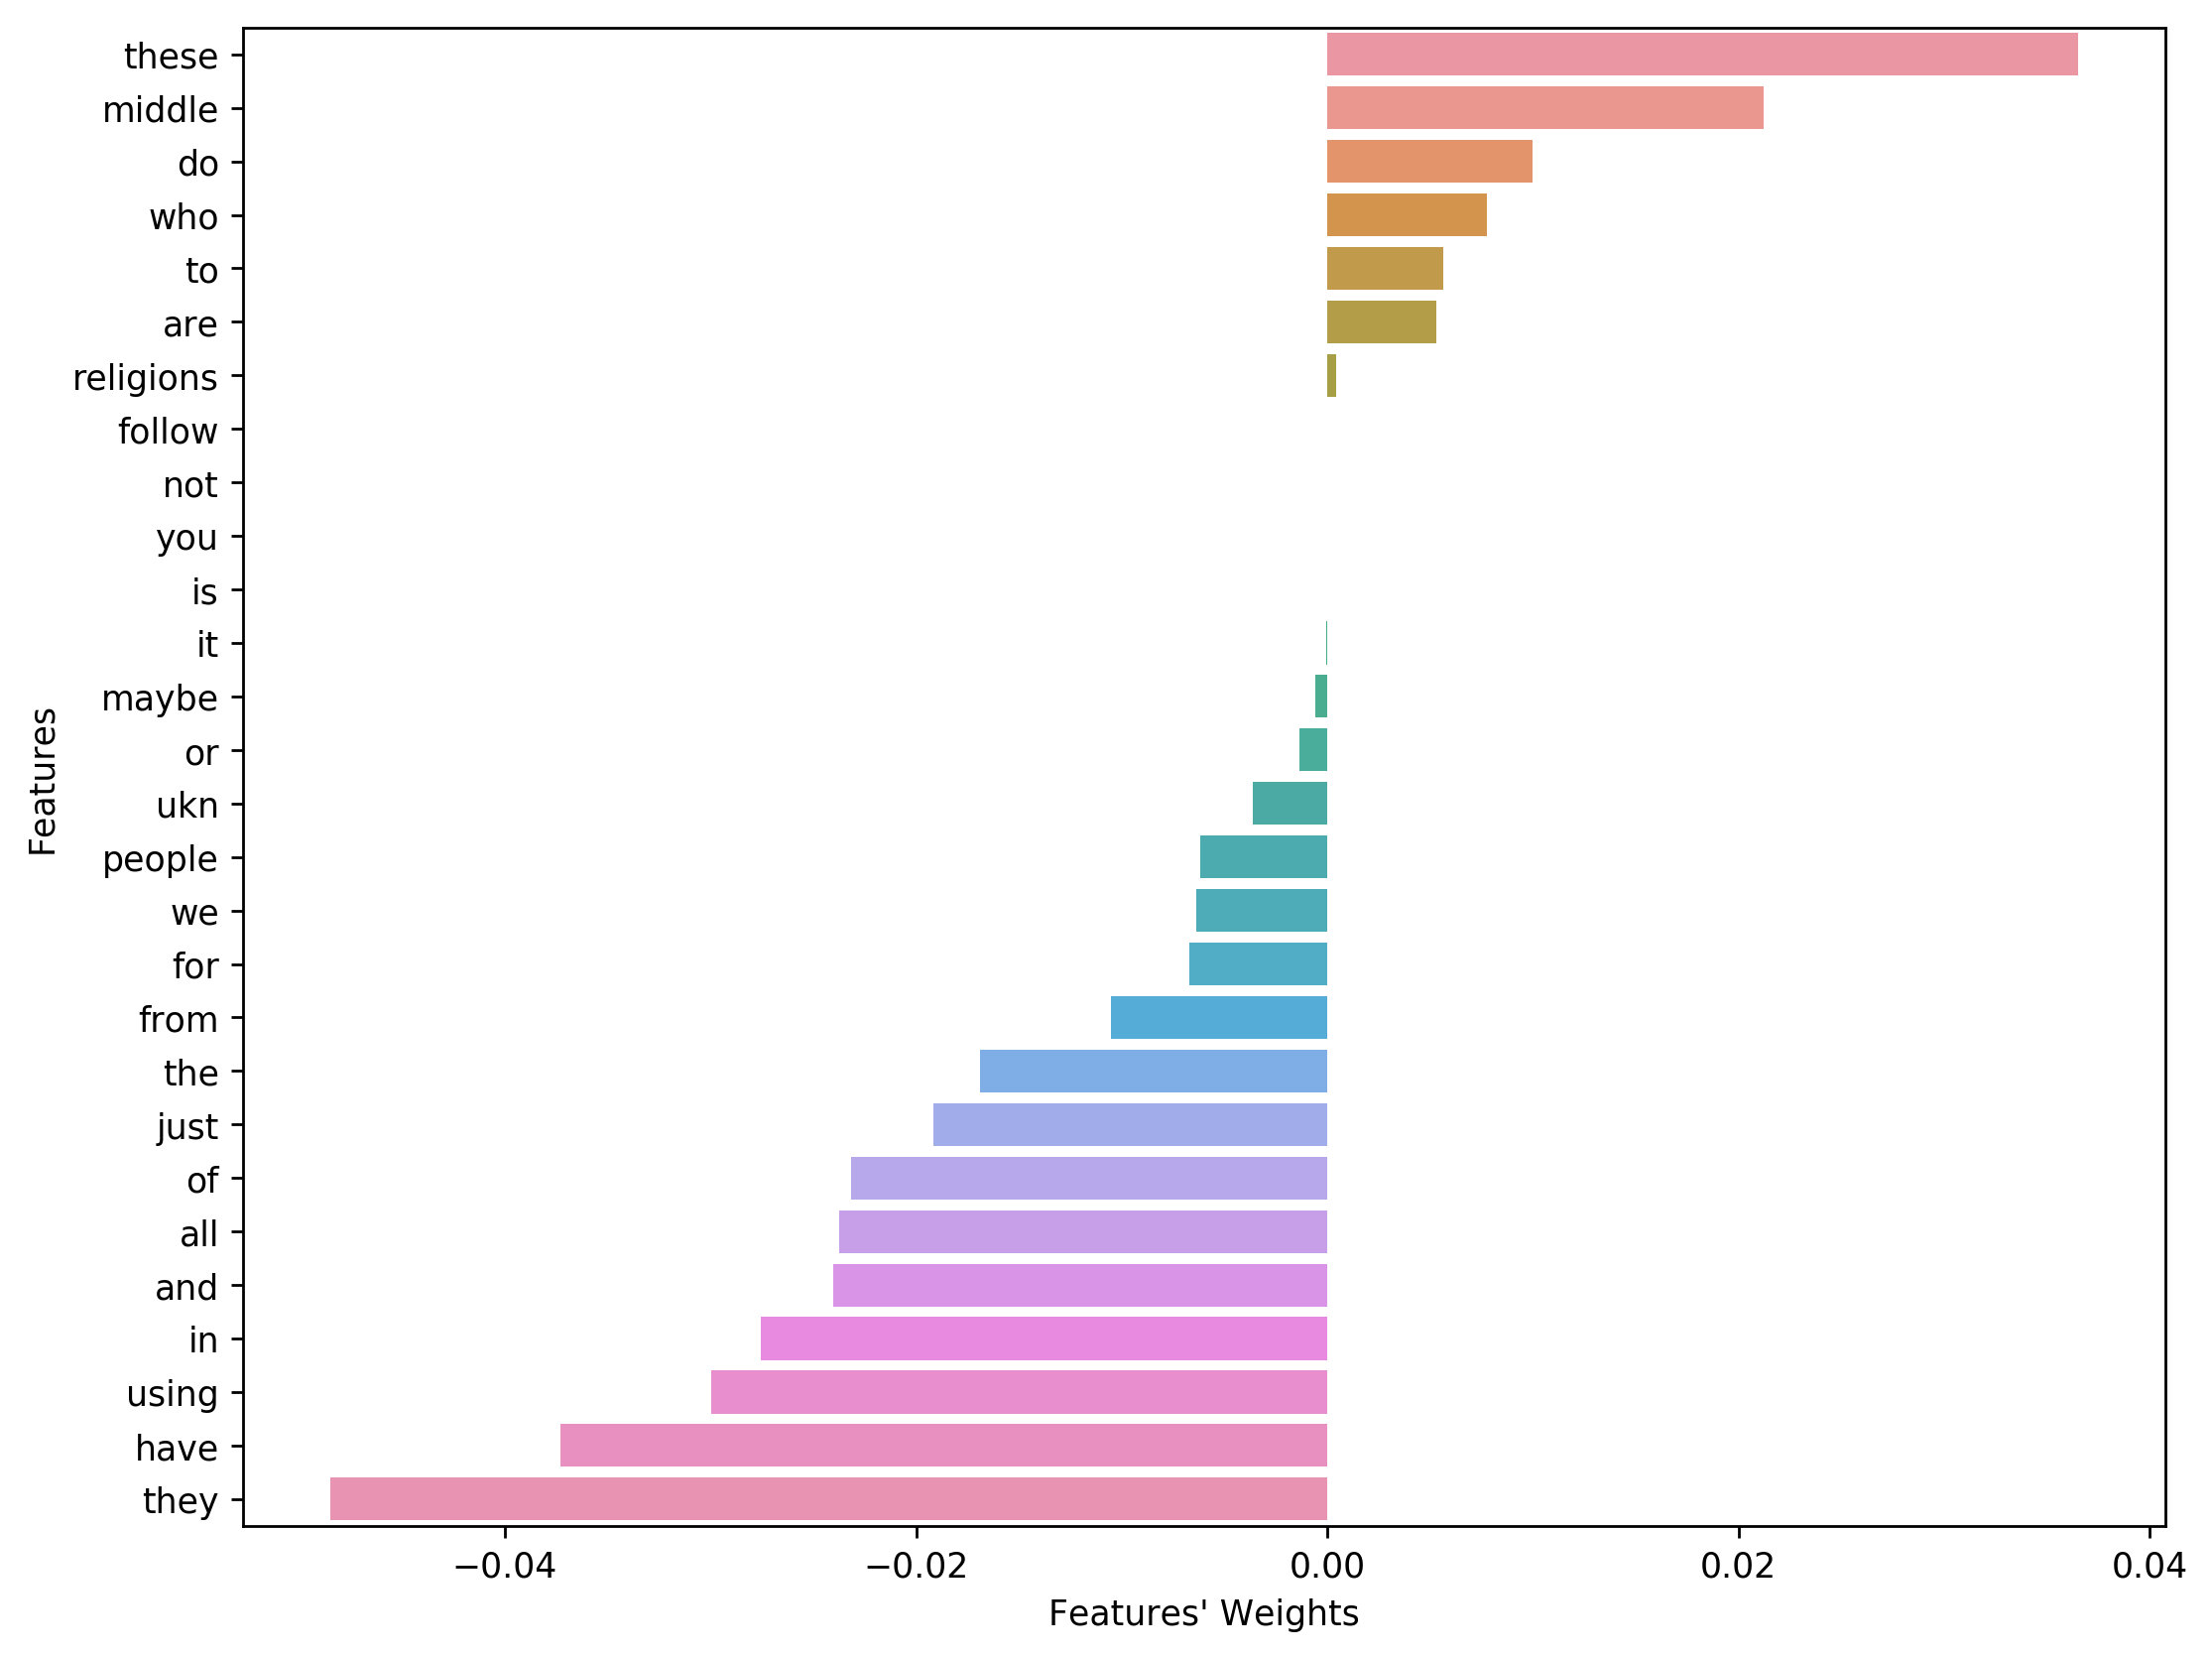

In [109]:
plt.figure(num=None, figsize=(10, 8), dpi=250, facecolor='w', edgecolor='k')
i_weights = pd.DataFrame({"Features": names, 
                                  "Features' Weights":weights[0]})
i_weights = i_weights.sort_values(by="Features' Weights", ascending=False)
i_weights = i_weights.drop_duplicates()
sns.barplot(x="Features' Weights", y="Features", data=i_weights)
plt.show()

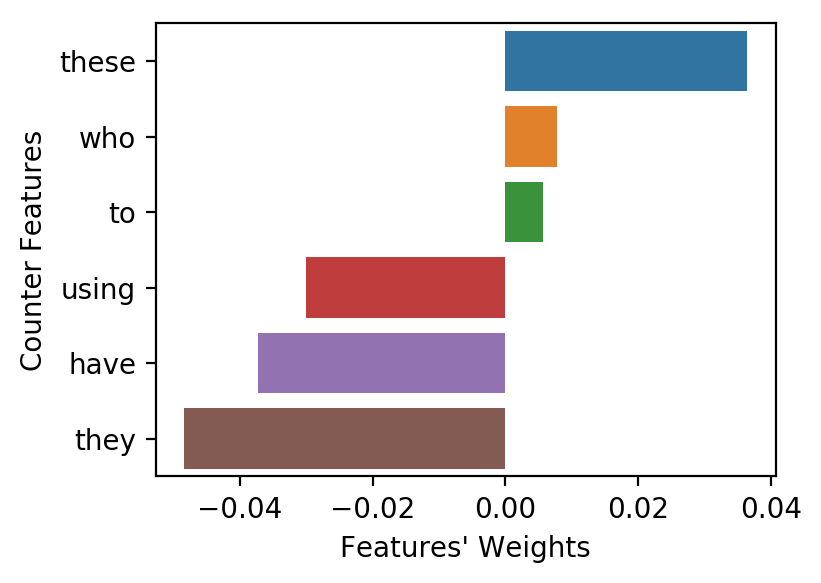

In [110]:
counter_weights = []
counter_features = []
for i in range(len(weights[0])):
    if weights[0][i]!=0:
        if names[i] not in X_T[22].lower():
            counter_weights.append(weights[0][i])
            counter_features.append(names[i])
co_weights = pd.DataFrame({"Counter Features": list(counter_features), 
                                  "Features' Weights": list(counter_weights)})
co_weights = co_weights.sort_values(by="Features' Weights", ascending=False)
co_weights = pd.concat([co_weights.head(3),co_weights.tail(3)])
plt.figure(num=None, figsize=(4, 3), dpi=200, facecolor='w', edgecolor='k')
sns.barplot(x="Features' Weights", y="Counter Features", data=co_weights)
#plt.xticks(rotation=90)
#plt.title(str('Features not appearing in the instance'))
plt.show()

In [117]:
lime_predict(['or maybe just do not follow they UKN religions from the middle UKN'])[0][1]

0.699709